Лабораторная работа №5
Выполнил студент гр. КИ21-17/1б Самарин Никита

### Задачи:
реализовать item-based/user-based подход
реализовать модель подсчета рейтинга с использованием кластеризации (количество кластеров обосновать)
посчитать рейтинги с помощью матричной факторизации SVD/NMF

In [199]:
import matplotlib.pyplot as plt
import numpy as np
import random
import pandas as pd
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from sklearn import preprocessing
from numpy.linalg import svd
from collections import Counter
import itertools
import math

In [200]:
movie_genres = pd.read_csv("movie_genres.dat", sep='\t')
user_rated_movies = pd.read_csv("user_ratedmovies.dat", sep='\t').drop('date_day	date_month	date_year	date_hour	date_minute	date_second'.split('\t'), axis=1)

In [3]:
movie_genres

,movieID,genre
0,1,Adventure
1,1,Animation
2,1,Children
3,1,Comedy
4,1,Fantasy
...,...,...
20804,65126,Comedy
20805,65126,Drama
20806,65130,Drama
20807,65130,Romance


In [4]:
user_rated_movies

,userID,movieID,rating
0,75,3,1.0
1,75,32,4.5
2,75,110,4.0
3,75,160,2.0
4,75,163,4.0
...,...,...,...
855593,71534,44555,4.0
855594,71534,46578,4.0
855595,71534,48516,4.5
855596,71534,61075,5.0


In [5]:
n_users = len(user_rated_movies.userID.unique())
n_movies = len(user_rated_movies.movieID.unique())
f'movies: {n_movies}, users: {n_users}'

'movies: 10109, users: 2113'

In [6]:
user2idx = {userID: i for i, userID in enumerate(user_rated_movies.userID.unique())}
idx2user = {i: user for user, i in user2idx.items()}

movie2idx = {movieID: i for i, movieID in enumerate(user_rated_movies.movieID.unique())}
idx2movie = {i: movie for movie, i in movie2idx.items()}

user_idx = user_rated_movies['userID'].apply(lambda x: user2idx[x]).values
movie_idx = user_rated_movies['movieIDIdx'] = user_rated_movies['movieID'].apply(lambda x: movie2idx[x]).values
hours = user_rated_movies['rating'].values

zero_matrix = np.zeros(shape=(n_users, n_movies))
user_movie_pref = zero_matrix.copy()
user_movie_pref[user_idx, movie_idx] = 1

user_movie_interactions = zero_matrix.copy()

user_movie_interactions[user_idx, movie_idx] = hours

user_movie = pd.DataFrame(user_movie_interactions, columns=user_rated_movies['movieID'].unique(), index=user_rated_movies['userID'].unique())
user_movie

,3,32,110,160,163,165,173,296,353,420,...,2666,763,60618,63276,63662,62796,3585,59065,4421,8393
75,1.0,4.5,4.0,2.0,4.0,4.5,3.5,5.0,3.5,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
78,0.0,5.0,3.5,0.0,0.0,0.0,0.0,4.5,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
127,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
170,0.0,4.0,0.0,0.0,0.0,3.0,0.0,4.5,0.0,2.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
175,0.0,4.0,5.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71497,0.0,0.0,3.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
71509,0.0,3.0,0.0,0.0,0.0,0.0,0.0,4.5,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
71525,0.0,0.0,5.0,0.0,0.0,5.0,0.0,0.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
71529,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
user_movie = user_movie.replace(0, np.nan)
user_movie = user_movie.sub(user_movie.mean(axis=1), axis=0)
user_corr = user_movie.T.corr()
movie_corr = user_movie.corr()

In [8]:
user_movie.head()

,3,32,110,160,163,165,173,296,353,420,...,2666,763,60618,63276,63662,62796,3585,59065,4421,8393
75,-2.463636,1.036364,0.536364,-1.463636,0.536364,1.036364,0.036364,1.536364,0.036364,-1.463636,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
78,NaN,0.878205,-0.621795,NaN,NaN,NaN,NaN,0.378205,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
127,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
170,NaN,0.933735,NaN,NaN,NaN,-0.066265,NaN,1.433735,NaN,-0.566265,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
175,NaN,-0.307971,0.692029,NaN,NaN,NaN,NaN,0.692029,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
user_corr.head()

,75,78,127,170,175,190,267,325,383,476,...,71331,71420,71478,71483,71487,71497,71509,71525,71529,71534
75,1.000000,-0.088936,NaN,0.570133,-0.112645,-0.364190,0.449004,0.474772,0.000000,0.474634,...,0.571210,0.075635,0.124735,0.250435,0.068427,0.483859,0.378022,0.297820,0.487154,0.831522
78,-0.088936,1.000000,NaN,0.164055,0.170428,0.153264,0.330864,-0.049351,0.310902,0.132254,...,0.133482,-0.136631,-0.115713,0.132494,0.154064,-0.050585,0.284553,0.148404,-0.089425,0.419659
127,NaN,NaN,1.0,NaN,1.000000,1.000000,1.000000,0.451869,NaN,NaN,...,0.519875,-0.250087,NaN,NaN,NaN,NaN,NaN,-0.271163,NaN,NaN
170,0.570133,0.164055,NaN,1.000000,0.281336,-0.230146,0.484321,0.149081,0.412722,0.207416,...,0.540579,-0.099379,0.069702,-0.291594,-0.130951,0.207456,0.287347,-0.356262,-0.158425,-0.033531
175,-0.112645,0.170428,1.0,0.281336,1.000000,0.144357,0.299579,0.100223,0.338421,0.270972,...,0.276035,-0.050248,-0.024595,0.040960,0.119315,0.207318,0.355128,0.185841,0.090337,0.093465


In [10]:
movie_corr.head()

,3,32,110,160,163,165,173,296,353,420,...,2666,763,60618,63276,63662,62796,3585,59065,4421,8393
3,1.000000,-0.015368,0.111132,0.002217,0.200618,0.140425,0.055598,-0.078377,0.058541,0.359526,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32,-0.015368,1.000000,0.061669,-0.032359,-0.007163,-0.053268,-0.012604,0.242401,0.123062,-0.099941,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
110,0.111132,0.061669,1.000000,0.052782,0.188597,0.192570,0.074539,0.065980,0.195157,0.078604,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
160,0.002217,-0.032359,0.052782,1.000000,0.012218,0.119334,0.273126,-0.136461,0.044609,0.244656,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
163,0.200618,-0.007163,0.188597,0.012218,1.000000,0.223179,0.258621,0.205331,0.148127,0.161411,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
user_corr.to_csv('user_corr', index=True, columns=user_corr.columns.values)
movie_corr.to_csv('movie_corr', index=True, columns=movie_corr.columns.values)
user_movie.to_csv('user_movie', index=True, columns=user_movie.columns.values)

# item-based/user-based подход

In [201]:
user_corr = pd.read_csv("user_corr", header=0, index_col=0)
movie_corr= pd.read_csv("movie_corr", header=0, index_col=0)
user_movie = pd.read_csv("user_movie", header=0, index_col=0)

In [202]:
def get_most_similar(df, user_id: int, n: int = 1) -> pd.DataFrame:
    queryset = df.sort_values(by=f'{user_id}', ascending=False)
    res = pd.DataFrame(queryset[f'{user_id}'][1:n + 1])
    res.columns = ['corr']
    if n == 1:
        return res[0]
    return res


In [203]:
def get_user_rated_movie(user_id: int, n=-1):
    queryset = user_rated_movies[user_rated_movies['userID'] == user_id]
    res = pd.DataFrame(queryset['movieID'])

    if n != -1:
        queryset = queryset.sort_values(by='rating', ascending=False) # type: ignore
        res = pd.DataFrame(queryset['movieID'].head(n))

    res.columns = ['movieID']
    return res

In [204]:
def get_user_movie_rate(user_id: int, movie_id: int) -> int:
    queryset = user_rated_movies[(user_rated_movies['userID'] == user_id) & (user_rated_movies['movieID'] == movie_id)]
    return 0 if queryset.empty else queryset['rating'].values[0]

In [205]:
def draw_common_movie_rates(user_1: int, user_2: int, movies_count: int = 5):
    user_1_movies = get_user_rated_movie(user_1)['movieID'].to_list()
    user_2_movies = get_user_rated_movie(user_2)['movieID'].to_list()

    common_movies = set(user_1_movies) & set(user_2_movies)
    common_movies = list(itertools.islice(common_movies, movies_count))

    user_1_movie_rating = []
    user_2_movie_rating = []

    for movie in common_movies:
        user_1_movie_rating.append(get_user_movie_rate(user_1, movie))
        user_2_movie_rating.append(get_user_movie_rate(user_2, movie))

    x = np.arange(len(common_movies))
    width = 0.37

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, user_1_movie_rating, width, label=f'user {user_1}')
    rects2 = ax.bar(x + width/2, user_2_movie_rating, width, label=f'user {user_2}')

    ax.set_ylabel('Rating')
    ax.set_title('Movie rating between two users')
    ax.set_xticks(x, common_movies)
    ax.legend()

    ax.bar_label(rects1, padding=3)
    ax.bar_label(rects2, padding=3)

    fig.tight_layout()

    plt.show()

In [206]:
get_most_similar(user_corr, 75, n=30)

,corr
14171,1.000000
36548,1.000000
46126,1.000000
26819,1.000000
23647,1.000000
1117,1.000000
20734,1.000000
53022,1.000000
16289,1.000000
54250,1.000000


In [207]:
get_most_similar(movie_corr, 3, n=444)

,corr
2638,1.000000
1406,1.000000
2744,1.000000
7133,1.000000
503,1.000000
...,...
7129,1.000000
2233,1.000000
5022,0.999999
7748,0.999997


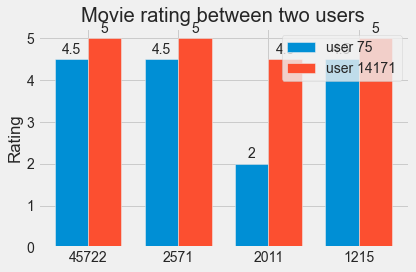

In [208]:
draw_common_movie_rates(75, 14171, 10)

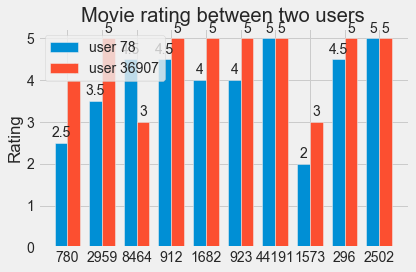

In [209]:
draw_common_movie_rates(78, 36907, 10)

# кластеризация

In [210]:
from kneed import KneeLocator

sse = []

if True:
    for k in range(1, 11):
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(user_movie.replace(np.nan, 0))
        sse.append(kmeans.inertia_)

    kl = KneeLocator(range(1, 11), sse, curve="convex", direction="decreasing")
    best_cluster_count = kl.elbow
    print(best_cluster_count)

C:\Projects\SFU\TVO\pr5\venv\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Projects\SFU\TVO\pr5\venv\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Projects\SFU\TVO\pr5\venv\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Projects\SFU\TVO\pr5\venv\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. 

3


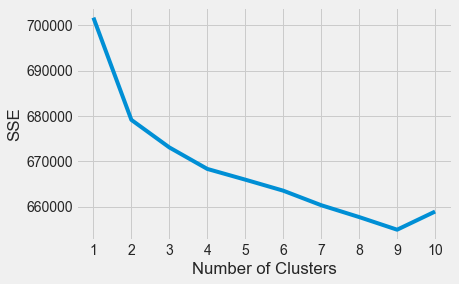

In [211]:
plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [212]:
#if best_cluster_count < 4:
#    best_cluster_count = 5

In [213]:
user_movie['label'] = KMeans(n_clusters=best_cluster_count).fit(user_movie.replace(np.nan, 0)).predict(user_movie.replace(np.nan, 0))

C:\Projects\SFU\TVO\pr5\venv\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [214]:
def get_user_cluster(user_id: int):
    return np.array(user_movie['label'].loc[[user_id]])[0]

In [215]:
for i in sorted(user_movie['label'].unique()):
    print(f'Users in cluster {i}: {len(user_movie[user_movie["label"] == i])}')

Users in cluster 0: 1
Users in cluster 1: 342
Users in cluster 2: 1770


In [216]:
def get_movie_rating_for_user(user_id: int, movie_id: int):
    return np.array(user_movie.groupby('label')[str(movie_id)].mean().loc[[get_user_cluster(user_id)]])[0]

In [217]:
def get_movie_predicts(user_id, n = 10):
    predicts = pd.DataFrame(columns=["original", "predict"])
    for i in range(0, n):
        movie_id = int(user_movie.columns[i])
        original = np.array(user_movie[str(movie_id)].loc[[user_id]])[0]
        predict = get_movie_rating_for_user(user_id, movie_id)
        predicts.loc[len(predicts.index)] = [original, predict]
    return predicts

In [218]:
get_movie_rating_for_user(75, 3)

-0.5459961347925598

In [219]:
predicts = get_movie_predicts(75, 10)
predicts

,original,predict
0,-2.463636,-0.545996
1,1.036364,0.384125
2,0.536364,0.276274
3,-1.463636,-0.919977
4,0.536364,-0.119542
5,1.036364,-0.077302
6,0.036364,-0.870377
7,1.536364,0.568185
8,0.036364,0.069973
9,-1.463636,-0.764624


<Axes: >

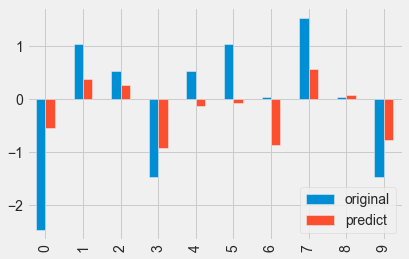

In [220]:
predicts.plot(y=["original", "predict"], kind="bar")

# SVD

In [221]:
user_movie = user_movie.fillna(0)
user_movie

,3,32,110,160,163,165,173,296,353,420,...,763,60618,63276,63662,62796,3585,59065,4421,8393,label
75,-2.463636,1.036364,0.536364,-1.463636,0.536364,1.036364,0.036364,1.536364,0.036364,-1.463636,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,2
78,0.000000,0.878205,-0.621795,0.000000,0.000000,0.000000,0.000000,0.378205,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,2
127,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,2
170,0.000000,0.933735,0.000000,0.000000,0.000000,-0.066265,0.000000,1.433735,0.000000,-0.566265,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,2
175,0.000000,-0.307971,0.692029,0.000000,0.000000,0.000000,0.000000,0.692029,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71497,0.000000,0.000000,-0.046000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,2
71509,0.000000,-0.381055,0.000000,0.000000,0.000000,0.000000,0.000000,1.118945,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.381055,1
71525,0.000000,0.000000,1.024155,0.000000,0.000000,1.024155,0.000000,0.000000,0.000000,-0.975845,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,2
71529,-1.391089,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,2


In [222]:
u, s, vh = svd(user_movie.values)
u, s, vh

(array([[-5.31116106e-03, -3.49676819e-03,  1.45345839e-02, ...,
          3.67048754e-03,  3.61706785e-03, -6.77394048e-04],
        [-1.02983561e-02, -2.66297970e-02, -7.27570231e-03, ...,
         -1.87128216e-03,  7.96008423e-04,  2.07045391e-05],
        [-1.89705631e-03, -2.36091019e-03,  7.97048999e-03, ...,
          4.81226592e-03, -1.29667836e-03,  5.64750502e-04],
        ...,
        [-1.43664614e-02,  1.92625527e-02,  1.47527592e-02, ...,
         -1.12074634e-03,  1.34419449e-03, -2.69381169e-04],
        [-5.65183451e-03,  1.13727881e-03,  1.52012377e-02, ...,
          6.71352872e-03,  5.63935333e-03,  3.87636033e-03],
        [-4.07453945e-03, -1.60400890e-02, -9.96338080e-04, ...,
          5.74518791e-03, -2.97673679e-03, -6.68876287e-04]]),
 array([2.54243368e+02, 1.18995752e+02, 1.08917772e+02, ...,
        6.17082484e-01, 5.08453775e-01, 1.28995361e-01]),
 array([[ 1.65425319e-02, -6.67289602e-02, -4.15557221e-02, ...,
          3.93111492e-05,  4.57205881e-05, -2

In [223]:
len(u), len(u[0]), u[0]

(2113,
 2113,
 array([-0.00531116, -0.00349677,  0.01453458, ...,  0.00367049,
         0.00361707, -0.00067739]))

In [224]:
len(s), s

(2113,
 array([2.54243368e+02, 1.18995752e+02, 1.08917772e+02, ...,
        6.17082484e-01, 5.08453775e-01, 1.28995361e-01]))

In [225]:
len(vh), len(vh[0]), vh[0]

(10110,
 10110,
 array([ 1.65425319e-02, -6.67289602e-02, -4.15557221e-02, ...,
         3.93111492e-05,  4.57205881e-05, -2.01498396e-01]))

Определим функцию `cosine_similarity` для вычисления косинусного сходства между двумя векторами.

In [226]:
def cosine_similarity(v, u):
    return (v @ u) / (np.linalg.norm(v) * np.linalg.norm(u))

Определим функцию `get_svd_similar` для получения столбца, наиболее похожего на данный столбец в матрице, на основе косинусного сходства.

In [227]:
def get_svd_similar(id: int, _vh):
    highest_similarity = -np.inf
    highest_sim_col = -1

    for col in range(1, _vh.shape[1]):
        if col == id:
            continue

        similarity = cosine_similarity(_vh[:, id], _vh[:, col])

        if similarity > highest_similarity:
            highest_similarity = similarity
            highest_sim_col = col

    return highest_sim_col

In [228]:
user_number = 1
similar_user_number = get_svd_similar(user_number, vh)
base_user_id = user_movie.index[user_number]
similar_user_id = user_movie.index[similar_user_number]

f'Base user - {base_user_id}, similar user - {similar_user_id}'

'Base user - 78, similar user - 4375'

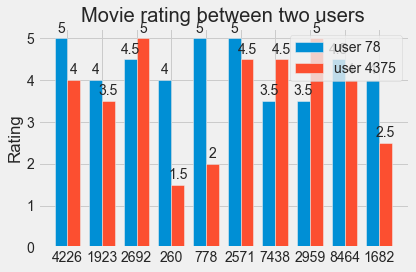

In [229]:
draw_common_movie_rates(base_user_id, similar_user_id, 10)